In [6]:
import os
import sys
PATH = os.path.join(os.getcwd(), '..')
sys.path.append(PATH)
print(f'module imported')

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

from src.common.lin_utils import gram_matrix
from src.model.meta_model import MetaModel
from src.model.hook import VGGHooks
from src.data.tfms import get_style_transforms

%load_ext autoreload
%autoreload 2

module imported
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Setup Model and Image

In [26]:
HOOK_VGG_IDXS = [3, 8, 15, 22]
STYLE_PATH = os.path.join('..', 'style', 'cuson_arts.jpg')
IMG_SIZE = 128

# setup model
model = MetaModel().cuda()

# setup images
style_img = Image.open(STYLE_PATH).convert('RGB')
style_t = get_style_transforms(IMG_SIZE)(style_img)
style_t = style_t.repeat(1, 1, 1, 1).cuda()
style_t.shape

2020-04-07 21:24:45,410 — root — INFO — meta model is set


torch.Size([1, 3, 153, 128])

In [27]:
ms = [model.vgg.subnet[idx] for idx in HOOK_VGG_IDXS]
hooks = VGGHooks(ms, detach = False)

#### 2. Get Gram Matrix

In [28]:
t = model(style_t, vgg_only = True)

In [29]:
for i in hooks.stored:
    print(i.shape)

torch.Size([1, 64, 153, 128])
torch.Size([1, 128, 76, 64])
torch.Size([1, 256, 38, 32])
torch.Size([1, 512, 19, 16])


In [30]:
gms = [gram_matrix(t) for t in hooks.stored]

In [31]:
gms[0].shape

torch.Size([1, 64, 64])

#### 3. Visualize Parallel Gram Matrix

In [33]:
def tensor2np(t_ls):
    """
    convert list of tensor to list of numpy
    """
    outs = []
    for t in t_ls:
        tmp = t.detach().cpu().numpy()
        outs.append(tmp)
    return outs

In [65]:
def plot_gram_matrix_pairs(
    gm1, gm2, fname = None, 
    title1 = 'Content Image Gram Matrix', title2 = 'Style Image Gram Matrix'
    ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (15, 8))
    ax1.imshow(gm1[0], vmin = 0, vmax = 0.08)
    ax1.set_title(title1)
    ax2.imshow(gm2[0], vmin = 0, vmax = 0.08)
    ax2.set_title(title2)
    plt.tight_layout()
    if fname is not None:
        fig.savefig(fname)
        print(f'figure saved: {fname}')
    return None

In [44]:
np_gms = tensor2np(gms)

for gm in np_gms:
    print(f'gm.shape = {gm.shape}, type(gm) = {type(gm)}')
    print(f'mean = {gm.mean()}, std = {gm.std()}')

gm.shape = (1, 64, 64), type(gm) = <class 'numpy.ndarray'>
mean = 0.006600883789360523, std = 0.009531776420772076
gm.shape = (1, 128, 128), type(gm) = <class 'numpy.ndarray'>
mean = 0.009192997589707375, std = 0.011511634103953838
gm.shape = (1, 256, 256), type(gm) = <class 'numpy.ndarray'>
mean = 0.0069821542128920555, std = 0.011233721859753132
gm.shape = (1, 512, 512), type(gm) = <class 'numpy.ndarray'>
mean = 0.0006642735097557306, std = 0.0017719134921208024


figure saved: test.png


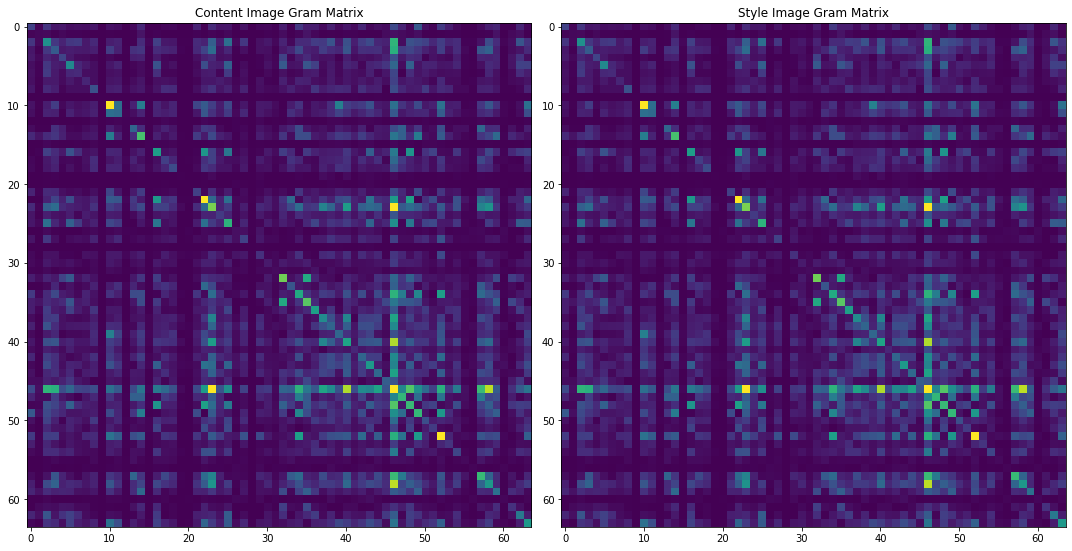

In [68]:
plot_gram_matrix_pairs(np_gms[0], np_gms[0], fname = 'test.png')